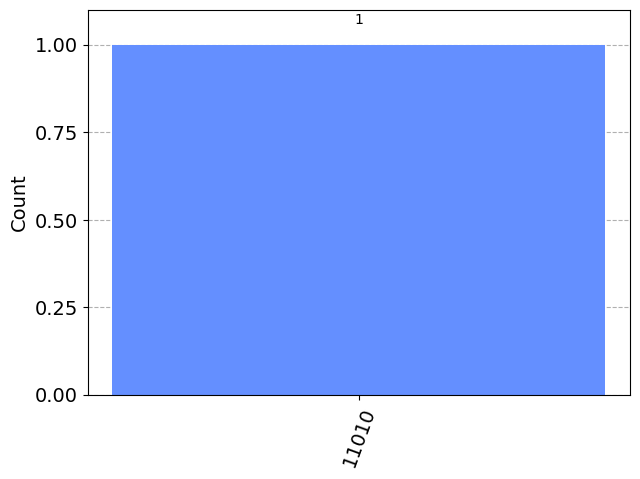

In [11]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit_aer.noise import (NoiseModel, QuantumError, pauli_error, depolarizing_error)
from IPython.display import display
from qiskit.tools.visualization import plot_histogram



count = 100
total = 0
ave_err_num = 0
num_qubits_linux = 5 # for Linux
num_qubits_mac = 24 # for mac
backend = Aer.get_backend('qasm_simulator')


class User:
    def __init__(self, username: str, sharekey, socket_classical, socket_quantum):
        self.username = username
        self.sharekey = sharekey
        self.socket_classical = socket_classical
        self.socket_quantum = socket_quantum

    def create_socket_for_classical(self):
        import socket
        SERVER_HOST_CLASSICAL = '127.0.0.1'
        SERVER_PORT_CLASSICAL = 12001
        client_socket_classical = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        client_socket_classical.connect((SERVER_HOST_CLASSICAL, SERVER_PORT_CLASSICAL))
        self.socket_classical = client_socket_classical        

user0 = User("Alice", any, any, any) 
user1 = User("Bob", any, any, any)

def qrng(n):
    qc = QuantumCircuit(n,n)
    for i in range(n):
        qc.h(i) # The Hadamard gate has the effect of projecting a qubit to a 0 or 1 state with equal probability.
    qc.measure(list(range(n)),list(range(n)))
    result = execute(qc,backend,shots=1).result()
    counts = result.get_counts(0)
    max_key = max(counts, key=counts.get)
    bits = ''.join(list(reversed(max_key))) 
    return bits


# qubit encodings in specified bases
def encode_qubits(n,k,a):
    # Create quantum circuit with n qubits and n classical bits
    qc = QuantumCircuit(n,n) 
    for i in range(n):
        if a[i] == '0':
            if k[i] == '1':
                qc.x(i)
        else:
            if k[i] == '0':
                qc.h(i)
            else: 
                qc.x(i)
                qc.h(i) 
    qc.barrier()
    return qc


def compose_quantum_circuit(n, alice_bits, a) -> QuantumCircuit:
    qc = QuantumCircuit(n,n)
    qc.measure_all()
    qc.compose(encode_qubits(n, alice_bits, a), inplace=True)
    return qc


def apply_noise_model():
    p_meas = 0.5
    error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")

    return noise_model


def bob_measurement(qc,bob_basis,noise_model):
    l = len(bob_basis)
    for i in range(l): 
        if bob_basis[i] == '1': # In case of Diagonal basis
            qc.h(i)

    qc.measure(list(range(l)),list(range(l))) 
    result = execute(qc,backend,shots=10, noise_model=noise_model).result() 
    counts = result.get_counts(0)
    max_key = max(counts, key=counts.get)
    bits = ''.join(list(reversed(max_key)))
    print("Bob bits: " + bits)

    qc.barrier() 
    return [qc,bits]


# check where bases matched
def check_bases(b1,b2):
    check = ''
    matches = 0
    for i in range(len(b1)):
        if b1[i] == b2[i]: 
            check += "Y" 
            matches += 1
        else:
            check += "-"
    return [check,matches]

# check where measurement bits matched
def check_bits(b1,b2,bck):
    check = ''
    for i in range(len(b1)):
        if b1[i] == b2[i] and bck[i] == 'Y':
            check += 'Y'
        elif b1[i] == b2[i] and bck[i] != 'Y':
            check += 'R'
        elif b1[i] != b2[i] and bck[i] == 'Y':
            check += '!'
        elif b1[i] != b2[i] and bck[i] != 'Y':
            check += '-'

    return check

def compare_bases(n, ab_bases, ab_bits, alice_bits, bob_bits):
    ka = ''  # kaの初期化
    kb = ''  # kbの初期化
    for i in range(n):
        if ab_bases[i] == 'Y':
            ka += alice_bits[i]
            kb += bob_bits[i]
    return ka, kb

n = 5
alice_bits = '00000'
alice_basis = '00000'
bob_basis = '00000'

qc = QuantumCircuit(n,n)
for i in range(n):
    qc.h(i) # The Hadamard gate has the effect of projecting a qubit to a 0 or 1 state with equal probability.
qc.measure(list(range(n)),list(range(n)))
result = execute(qc,backend,shots=1).result()
counts = result.get_counts(0)
max_key = max(counts, key=counts.get)
bits = ''.join(list(reversed(max_key))) 
plot_histogram(counts)

# qc = compose_quantum_circuit(num_qubits_linux, alice_bits, alice_basis)

# noise_model = apply_noise_model()

# l = len(bob_basis)
# for i in range(l): 
#     if bob_basis[i] == '1': # In case of Diagonal basis
#         qc.h(i)

# qc.measure(list(range(l)),list(range(l))) 
# result = execute(qc,backend,shots=100, noise_model=noise_model).result() 
# counts = result.get_counts(0)

# max_key = max(counts, key=counts.get)
# bits = ''.join(list(reversed(max_key)))
# print("Bob's bits " + bits)
# plot_histogram(counts)
